In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=3)
pd.set_option("display.precision", 3)

In [3]:

train_feat = pd.read_csv("data/training_set_features.csv")
train_target = pd.read_csv("data/training_set_labels.csv")
df = pd.merge(train_feat, train_target, on="respondent_id")
del(train_feat, train_target)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [5]:
df.isna().sum() / df.shape[0] * 100

respondent_id                   0.000
h1n1_concern                    0.344
h1n1_knowledge                  0.434
behavioral_antiviral_meds       0.266
behavioral_avoidance            0.779
behavioral_face_mask            0.071
behavioral_wash_hands           0.157
behavioral_large_gatherings     0.326
behavioral_outside_home         0.307
behavioral_touch_face           0.479
doctor_recc_h1n1                8.088
doctor_recc_seasonal            8.088
chronic_med_condition           3.636
child_under_6_months            3.070
health_worker                   3.010
health_insurance               45.958
opinion_h1n1_vacc_effective     1.464
opinion_h1n1_risk               1.453
opinion_h1n1_sick_from_vacc     1.479
opinion_seas_vacc_effective     1.730
opinion_seas_risk               1.925
opinion_seas_sick_from_vacc     2.011
age_group                       0.000
education                       5.268
race                            0.000
sex                             0.000
income_pover

In [6]:
# clearing dataframe from trash columns that mostly filled with NaNs
feat_nan_tresh = 0.2 # all feature columns with more than 20% NaNs will be deleted
tresh_columns = [col for col in df.columns if df[col].isna().sum() / df.shape[0] >= feat_nan_tresh]
df.drop(columns=tresh_columns, inplace=True)
tresh_columns

['health_insurance', 'employment_industry', 'employment_occupation']

In [7]:
# now it's slightly better
df.isna().sum() / df.shape[0] * 100

respondent_id                   0.000
h1n1_concern                    0.344
h1n1_knowledge                  0.434
behavioral_antiviral_meds       0.266
behavioral_avoidance            0.779
behavioral_face_mask            0.071
behavioral_wash_hands           0.157
behavioral_large_gatherings     0.326
behavioral_outside_home         0.307
behavioral_touch_face           0.479
doctor_recc_h1n1                8.088
doctor_recc_seasonal            8.088
chronic_med_condition           3.636
child_under_6_months            3.070
health_worker                   3.010
opinion_h1n1_vacc_effective     1.464
opinion_h1n1_risk               1.453
opinion_h1n1_sick_from_vacc     1.479
opinion_seas_vacc_effective     1.730
opinion_seas_risk               1.925
opinion_seas_sick_from_vacc     2.011
age_group                       0.000
education                       5.268
race                            0.000
sex                             0.000
income_poverty                 16.561
marital_stat

In [ ]:
df.drop(columns=["respondent_id"], inplace=True)
df.dropna(inplace=True)
df.isna().sum()

h1n1_concern                     92
h1n1_knowledge                  116
behavioral_antiviral_meds        71
behavioral_avoidance            208
behavioral_face_mask             19
behavioral_wash_hands            42
behavioral_large_gatherings      87
behavioral_outside_home          82
behavioral_touch_face           128
doctor_recc_h1n1               2160
doctor_recc_seasonal           2160
chronic_med_condition           971
child_under_6_months            820
health_worker                   804
opinion_h1n1_vacc_effective     391
opinion_h1n1_risk               388
opinion_h1n1_sick_from_vacc     395
opinion_seas_vacc_effective     462
opinion_seas_risk               514
opinion_seas_sick_from_vacc     537
age_group                         0
education                      1407
race                              0
sex                               0
income_poverty                 4423
marital_status                 1408
rent_or_own                    2042
employment_status           

In [9]:
df.head(5)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0


In [ ]:
# finding binary columns in dataset
binary_cols = [col for col in df.columns if \
                df[col].dtype != 'bool' and \
                df[col].nunique() == 2 and \
                sorted(df[col].unique().tolist()) == [0, 1]]
df[binary_cols] = df[binary_cols].astype(bool)
df[binary_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   h1n1_vaccine      26707 non-null  bool 
 1   seasonal_vaccine  26707 non-null  bool 
dtypes: bool(2)
memory usage: 52.3 KB


In [11]:
# now deal with categorical variables
df.dtypes[df.dtypes == 'O']

age_group            object
education            object
race                 object
sex                  object
income_poverty       object
marital_status       object
rent_or_own          object
employment_status    object
hhs_geo_region       object
census_msa           object
dtype: object

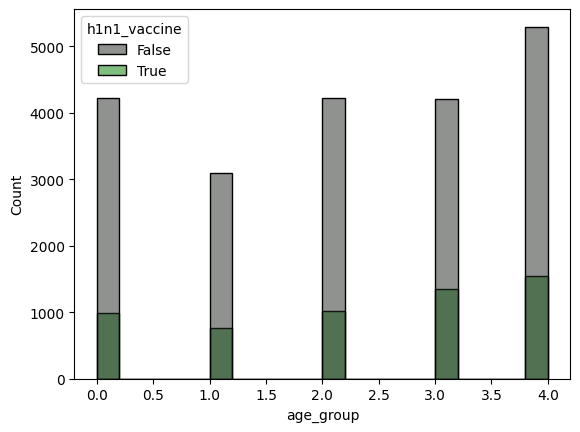

In [12]:
age_map = {
    "18 - 34 Years": 0,
    "35 - 44 Years": 1,
    "45 - 54 Years": 2,
    "55 - 64 Years": 3,
    "65+ Years": 4
}
df.age_group = df.age_group.map(age_map)
sns.histplot(df, x="age_group", hue="h1n1_vaccine", palette='dark:green');

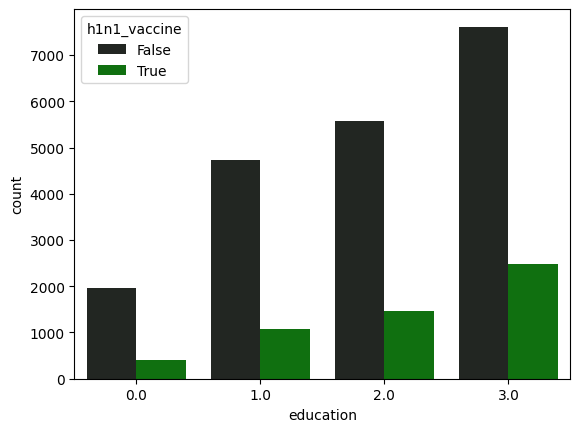

In [13]:
college_map = {
    "< 12 Years": 0,
    "12 Years": 1,
    "Some College": 2,
    "College Graduate": 3
}
df.education = df.education.map(college_map)
sns.countplot(df, x="education", hue='h1n1_vaccine', palette='dark:green');

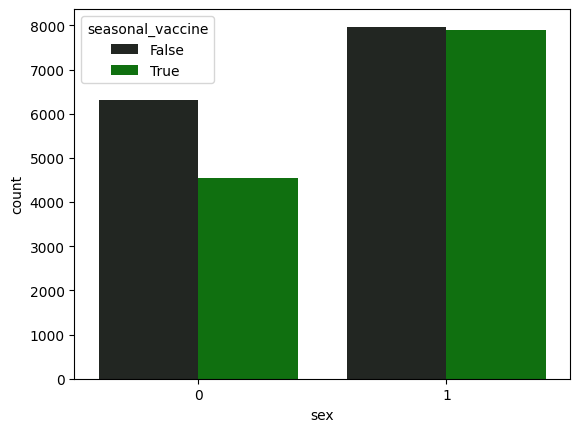

In [14]:
sex_map = {
    "Male": 0,
    "Female": 1
}
df.sex = df.sex.map(sex_map)
sns.countplot(df, x="sex", hue='seasonal_vaccine', palette='dark:green');

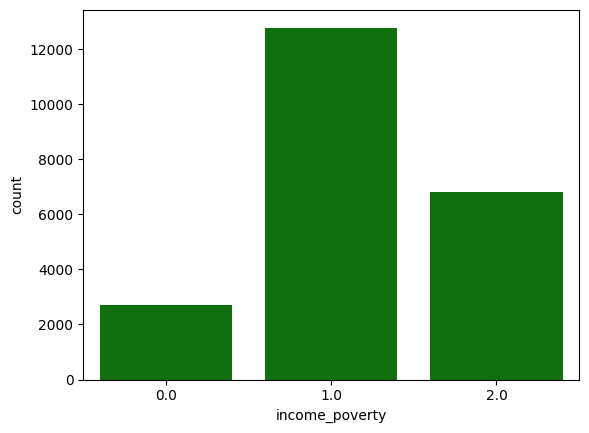

In [15]:
poverty_map = {
    "Below Poverty": 0,
    "<= $75,000, Above Poverty": 1,
    "> $75,000": 2
}
df.income_poverty = df.income_poverty.map(poverty_map)
sns.countplot(df, x="income_poverty", color='green');

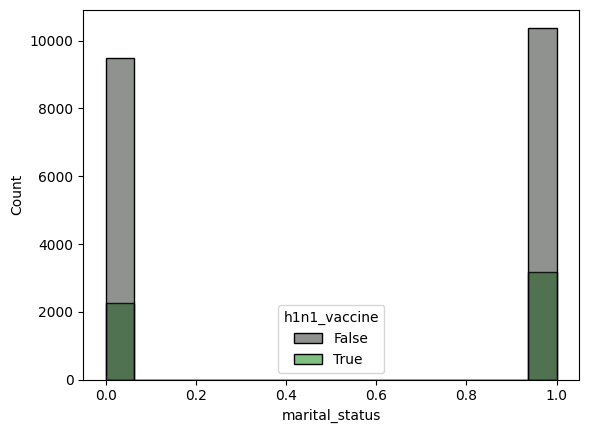

In [16]:
marital_map = {
    "Not Married": 0,
    "Married": 1
}
df.marital_status = df.marital_status.map(marital_map)
sns.histplot(df, x="marital_status", hue='h1n1_vaccine', palette='dark:green');

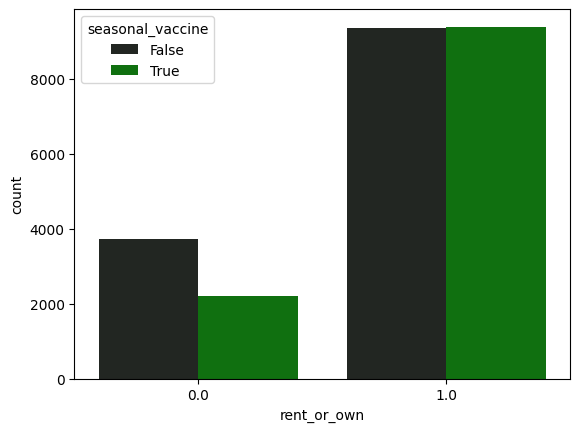

In [17]:
rent_map = {
    "Rent": 0,
    "Own": 1
}
df.rent_or_own = df.rent_or_own.map(rent_map)
sns.countplot(df, x="rent_or_own", hue='seasonal_vaccine', palette='dark:green');

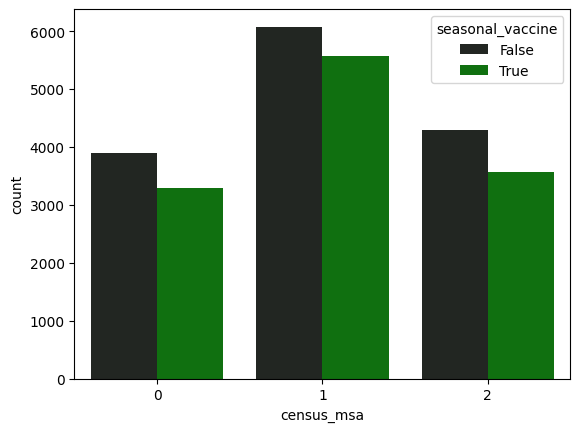

In [18]:
df.census_msa.unique()
census_map = {
    "Non-MSA": 0,
    "MSA, Not Principle  City": 1,
    "MSA, Principle City": 2
}
df.census_msa = df.census_msa.map(census_map)
sns.countplot(df, x="census_msa", hue='seasonal_vaccine', palette='dark:green');

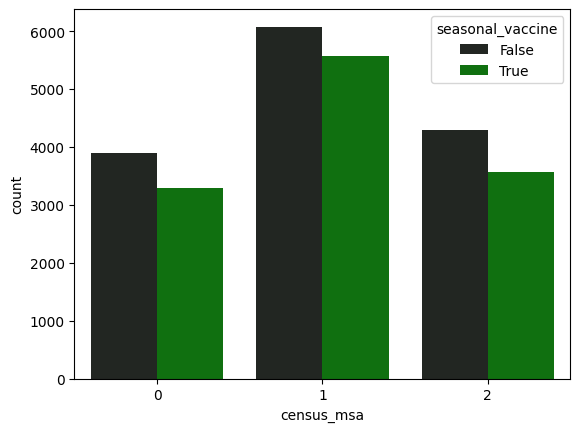

In [19]:
# now its much better
df.dtypes[df.dtypes == 'O']
sns.countplot(df, x="census_msa", hue='seasonal_vaccine', palette='dark:green');

In [20]:
df.employment_status.unique()
emp_map = {"Not in Labor Force": "NLF", 
           "Unemployed": "UE", 
           "Employed": "E"}
df.employment_status = df.employment_status.map(emp_map)

In [21]:
# update binary columns
binary_cols = [col for col in df.columns if \
                df[col].dtype != 'bool' and \
                df[col].nunique() == 2 and \
                sorted(df[col].unique().tolist()) == [0, 1]]
df[binary_cols] = df[binary_cols].astype(bool)
binary_cols = df.dtypes[df.dtypes == 'bool'].index.values

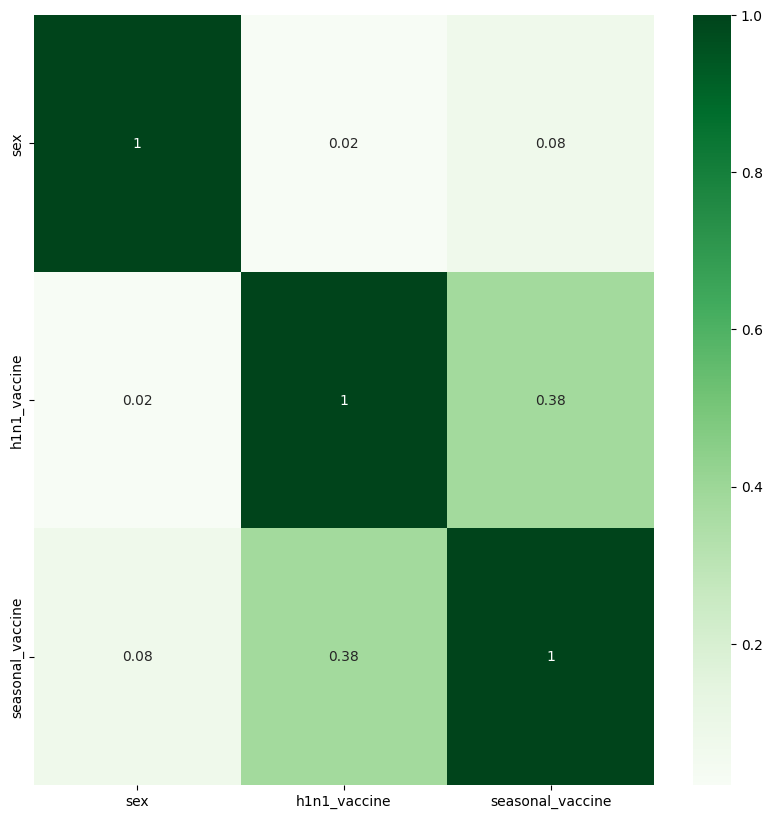

In [22]:
corr = df[binary_cols].corr(method='kendall').round(2)
_, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='Greens', ax=ax);

In [23]:
# convert floats to ints as floating point doesn't appear here
floats = df.dtypes[df.dtypes == 'float64'].index.values
ints = df.dtypes[df.dtypes == 'int64'].index.values
df[floats] = df[floats].astype(np.uint8)
df[ints] = df[ints].astype(np.uint8)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
df.dtypes

h1n1_concern                    uint8
h1n1_knowledge                  uint8
behavioral_antiviral_meds        bool
behavioral_avoidance             bool
behavioral_face_mask             bool
behavioral_wash_hands            bool
behavioral_large_gatherings      bool
behavioral_outside_home          bool
behavioral_touch_face            bool
doctor_recc_h1n1                 bool
doctor_recc_seasonal             bool
chronic_med_condition            bool
child_under_6_months             bool
health_worker                    bool
opinion_h1n1_vacc_effective     uint8
opinion_h1n1_risk               uint8
opinion_h1n1_sick_from_vacc     uint8
opinion_seas_vacc_effective     uint8
opinion_seas_risk               uint8
opinion_seas_sick_from_vacc     uint8
age_group                       uint8
education                       uint8
race                           object
sex                              bool
income_poverty                  uint8
marital_status                   bool
rent_or_own 

In [ ]:
categorical_cols = df.dtypes[df.dtypes == 'O'].index.values
numerical_cols = df.dtypes[df.dtypes == 'uint8'].index.values

<Axes: xlabel='h1n1_vaccine', ylabel='h1n1_concern'>

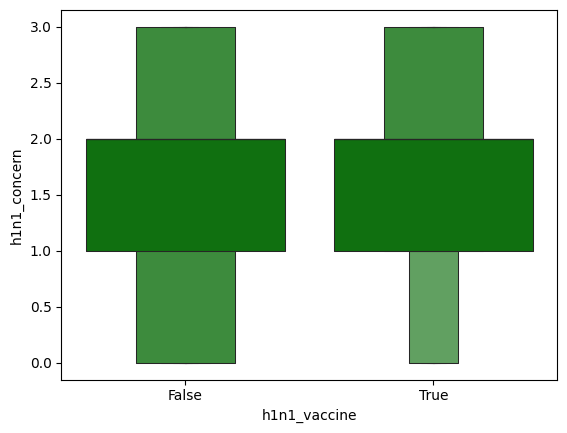

In [ ]:
sns.boxenplot(df, y="h1n1_concern", x="h1n1_vaccine", color='green')

<Axes: xlabel='h1n1_vaccine', ylabel='h1n1_knowledge'>

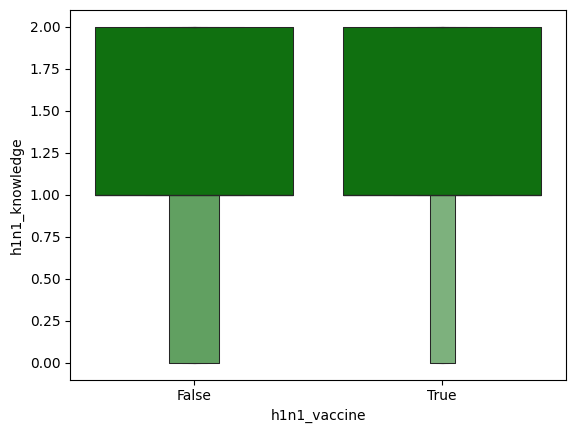

In [ ]:
sns.boxenplot(df, y="h1n1_knowledge", x="h1n1_vaccine", color='green')

<Axes: xlabel='h1n1_vaccine', ylabel='opinion_h1n1_risk'>

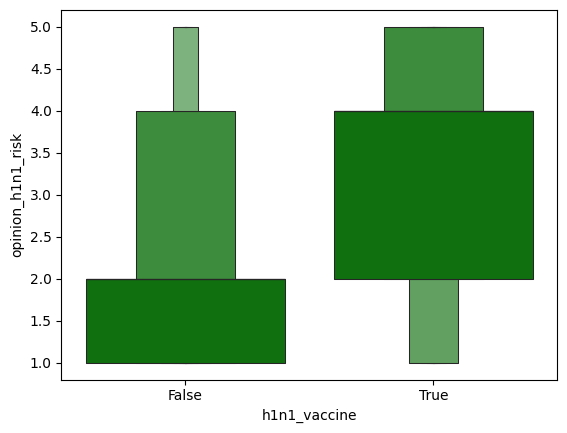

In [ ]:
sns.boxenplot(df, y="opinion_h1n1_risk", x="h1n1_vaccine", color='green')

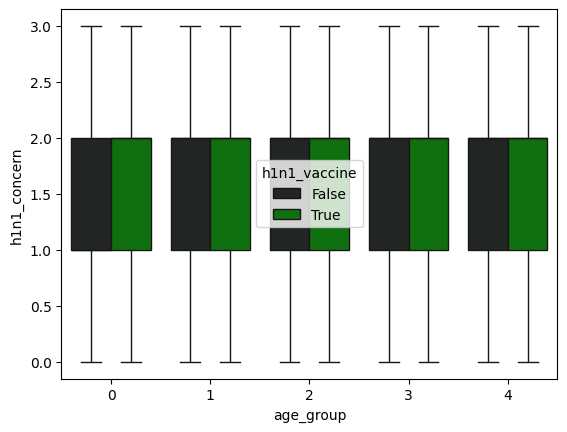

In [ ]:
sns.boxplot(df, x="age_group", y="h1n1_concern", palette='dark:green', hue="h1n1_vaccine");

<Axes: xlabel='race', ylabel='seasonal_vaccine'>

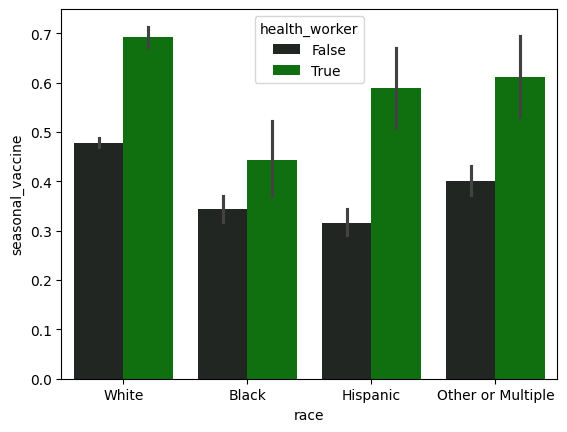

In [ ]:
sns.barplot(df, x="race", y="seasonal_vaccine", palette='dark:green', hue='health_worker')

In [ ]:
feat = df.drop(columns=["h1n1_vaccine", "seasonal_vaccine"])
target_h1n1 = df.h1n1_vaccine
target_seasonal = df.seasonal_vaccine
feat_ohe = pd.get_dummies(feat, columns=categorical_cols)

